# 张老师新给损失函数实现


## 加载各种包

In [1]:
# -*- coding:utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
# from sklearn.preprocessing import label_binarize
# from sklearn import preprocessing
# from sklearn import tree 

import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import scipy.io as scio
# import hiddenlayer as h
from visdom import Visdom
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
from torchviz import make_dot

import datetime
import os 

import sys
from utils.reuse import *
from utils.networks import *
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 预备操作
设置检查点、visdom 日志文件存储等日志性文件存储位置；
初始化 visdom,记得先在命令行输入 visdom 运行（python环境下）

In [2]:
# 以下是检查点路径
# 请在当前环境下 CMD 输入python -m visdom.server 或 visdom 启动监视器
# 数据处理现在已移至 emgDataprocess.ipynb
model_Dir = './/model//emgmk_cnn_0410_nl//'
if not os.path.exists(model_Dir):
    os.makedirs(model_Dir)

ckpDir = model_Dir+'ckp//'
if not os.path.exists(ckpDir):
    os.makedirs(ckpDir)

ckpDir_auc = './/ckp//emgmk_cnn_0323_nl//auc//'
if not os.path.exists(ckpDir_auc):
    os.makedirs(ckpDir_auc)

def get_current_time():
    return datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
print(get_current_time())

timeForSave = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

2022_04_10_19_19_27


In [3]:
# 以下是 visdom 监视窗口初始化，实现每次启用时重新加载，这里只写了 NameError 以防其他错误不能被发现
class visdom_account:
    def __init__(self):    
        self.port = 8097
        self.server = "http://localhost"
        self.base_url = "/"
        self.username = "admin"
        self.passward = "1234"
        self.evns = "train4"
viz_acnt = visdom_account()
vislogDir = model_Dir+'vislog//'
if not os.path.exists(vislogDir):
    os.makedirs(vislogDir)
def viz_init():
    try:
        viz
    except NameError:
        viz = Visdom(env=viz_acnt.evns,log_to_filename=vislogDir+'vislog_'+timeForSave)
        print('visdom has started')
    else:
        viz.close()
        del viz
        print('last visdom session closed')
        viz = Visdom(env=viz_acnt.evns,log_to_filename=vislogDir+'vislog_'+timeForSave)
        print('visdom has restarted')
    return viz
viz = viz_init()

Setting up a new session...


visdom has started


## 定义神经网络结构


In [4]:
# 自定义神经网络,CNN
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
# hdreshape = 32*1*3
hdreshape = 2
hdlayer_1 = 16
hdlayer_2 = 16
hdlayer_3 = 256
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128,\
             kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32,\
             kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, \
            kernel_size=3, padding=0)

        self.fc1 = nn.Linear(in_features=128*1*6, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        # self.fc3 = nn.Linear(in_features=hdlayer_2, out_features=hdlayer_3)
        self.out = nn.Linear(in_features=128, out_features=6)
        self.dr1 = nn.Dropout2d(0.2)

    def forward(self, t):
        # (1) input layer
        t = t
        # t = t.reshape(1,1,3)
        # t = t.unsqueeze(0)

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        # t = F.max_pool2d(t, kernel_size=2, stride=1)

        # (3) hidden conv layer
        # t = self.conv2(t)
        # t = F.relu(t)
        # t = self.dr1(t)
        # t = F.max_pool2d(t, kernel_size=2, stride=1)

        # (4) hidden linear layer
        t = t.reshape(-1, 128*1*6)
        # t = t.flatten(start_dim=0)
        t = self.fc1(t)
        t = F.relu(t)
        t = self.fc2(t)
        t = F.relu(t)
        # t = self.fc3(t)
        # t = F.relu(t)
        # t = self.dr1(t)

        # (5) output layer
        t = self.out(t)

        return t

net = Network()
# 打印网络，检查输入输出 shape是否正确
# print(net)
samplebatchsize = 1
summary(net,(1,1,6),batch_size = samplebatchsize,device = "cpu")
sampleInput = torch.randn(samplebatchsize,1,1,6).requires_grad_(True)
sampleOutput = net(sampleInput)
print('Outputshape:',sampleOutput.shape)
# framevision = make_dot(sampleOutput, params=dict(list(net.named_parameters()) + [('x',sampleInput)]))
# framevision.format = "png"
# framevision.direcory = "./"
# framevision.view()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [1, 128, 1, 6]           1,280
            Linear-2                   [1, 128]          98,432
            Linear-3                   [1, 128]          16,512
            Linear-4                     [1, 6]             774
Total params: 116,998
Trainable params: 116,998
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.45
Estimated Total Size (MB): 0.45
----------------------------------------------------------------
Outputshape: torch.Size([1, 6])


## 数据集加载、构建

In [5]:

dataarray = np.load('../data/WristDataForPINN-1/EMGSKdata-220409.npy',allow_pickle=True)
CNNdataset = dataarray.item()
print(type(CNNdataset))
# 加载自变量：因为数据头尾不少空缺，裁剪之
data_head = 11
data_end = 2000
data_time = CNNdataset['time'][data_head:data_end]
data_fcr= CNNdataset['fcr'][data_head:data_end]
data_fcu = CNNdataset['fcu'][data_head:data_end]
data_ecrl = CNNdataset['ecrl'][data_head:data_end]
data_ecrb = CNNdataset['ecrb'][data_head:data_end]
data_ecu = CNNdataset['ecu'][data_head:data_end]
data_angle = CNNdataset['angle'][data_head:data_end]
data_mf_fcr = CNNdataset['mf_fcr'][data_head:data_end]
data_mf_fcu = CNNdataset['mf_fcu'][data_head:data_end]
data_mf_ecrl = CNNdataset['mf_ecrl'][data_head:data_end]
data_mf_ecrb = CNNdataset['mf_ecrb'][data_head:data_end]
data_mf_ecu = CNNdataset['mf_ecu'][data_head:data_end]


<class 'dict'>


In [9]:
# 划分训练集与测试集，每5点抽取一点作为测试集
def DataSpliter(data):
    data_tr = []
    data_te = []
    for i in range(len(data)):
        if (i+1)%5 == 0:
            data_te.append(data[i,:])
        else:
            data_tr.append(data[i,:])
    data_tr = np.array(data_tr)
    data_te = np.array(data_te)
    return data_tr, data_te
# 自变量部分
tr_data_time,te_data_time = DataSpliter(data_time)
tr_data_fcr,te_data_fcr = DataSpliter(data_fcr)
tr_data_fcu,te_data_fcu = DataSpliter(data_fcu)
tr_data_ecrl,te_data_ecrl = DataSpliter(data_ecrl)
tr_data_ecrb,te_data_ecrb = DataSpliter(data_ecrb)
tr_data_ecu,te_data_ecu = DataSpliter(data_ecu)
# 因变量部分
tr_data_angle,te_data_angle = DataSpliter(data_angle)
tr_data_mf_fcr,te_data_mf_fcr = DataSpliter(data_mf_fcr)
tr_data_mf_fcu,te_data_mf_fcu = DataSpliter(data_mf_fcu)
tr_data_mf_ecrl,te_data_mf_ecrl = DataSpliter(data_mf_ecrl)
tr_data_mf_ecrb,te_data_mf_ecrb = DataSpliter(data_mf_ecrb)
tr_data_mf_ecu,te_data_mf_ecu = DataSpliter(data_mf_ecu)
print(tr_data_mf_ecu.shape,te_data_ecu.shape)
# 按需组合数据，这两函数其实可以合并成一个
def Data_conbine(data_1,data_2,data_3,data_4,data_5,data_6):
    data_train = []
    for i in range(len(data_1)):
        data_1t6 = np.hstack((data_1[i,:],data_2[i,:],data_3[i,:]\
            ,data_4[i,:],data_5[i,:],data_6[i,:]))
        data_1t6 = data_1t6.flatten()
        data_train.append(data_1t6)
    data_train = np.array(data_train)
    return data_train
# 多时间步组建数据，这个在这里暂时没用上，因此我把它暂时注掉了
# def establish_multi_timestep_data(data_X,data_X_2,data_Y,expect_time_length):
#     dataset = []
#     dataset_y = []
#     if expect_time_length >0:
#         length = len(data_X)-expect_time_length
#         for i in range(length):
#             data_1 = data_X[i:i+expect_time_length,:]
#             data_1 = data_1.flatten()
#             data_2 = data_X_2[i:i+expect_time_length,:]
#             data_2 = data_2.flatten()
#             data_12 = np.hstack((data_1,data_2))
#             dataset.append(data_12)
#             dataset_y.append(data_Y[i+expect_time_length-1,:])
#         dataset = np.array(dataset)
#         dataset_y = np.array(dataset_y)
#     return dataset, dataset_y
# 将自变量与因变量各自组合到一起，尺寸均为1*6
data_1t6_tr = Data_conbine(tr_data_time,tr_data_fcr,tr_data_fcu\
    ,tr_data_ecrl,tr_data_ecrb,tr_data_ecu)
data_1t6_te = Data_conbine(te_data_time,te_data_fcr,te_data_fcu\
    ,te_data_ecrl,te_data_ecrb,te_data_ecu)
data_7t12_tr = Data_conbine(tr_data_angle,tr_data_mf_fcr,tr_data_mf_fcu\
    ,tr_data_mf_ecrl,tr_data_mf_ecrb,tr_data_mf_ecu)
data_7t12_te = Data_conbine(te_data_angle,te_data_mf_fcr,te_data_mf_fcu\
    ,te_data_mf_ecrl,te_data_mf_ecrb,te_data_mf_ecu)
# 转为 tensor 格式
data_1t6_tr = torch.from_numpy(data_1t6_tr).to(torch.float32)
data_1t6_te = torch.from_numpy(data_1t6_te).to(torch.float32)
data_7t12_tr = torch.from_numpy(data_7t12_tr).to(torch.float32)
data_7t12_te = torch.from_numpy(data_7t12_te).to(torch.float32)

print(data_1t6_tr.shape,data_7t12_tr.shape,data_1t6_te.shape,\
    data_7t12_te.shape)

# # 需要一个指示前一时刻的标签，居然没注意到 cyc 每五取一后不再连续了，害
data_index_tr = np.linspace(0,1591,1592)
data_index_te = np.linspace(0,396,397)


(1592, 1) (397, 1)
torch.Size([1592, 6]) torch.Size([1592, 6]) torch.Size([397, 6]) torch.Size([397, 6])


In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图片转换为Tensor,归一化至[0,1]
])
class EMGSK_Dataset(Dataset):
 
    def __init__(self, data_x, data_y):
        self.data_x = data_x
        self.data_y = data_y
        self.transforms = transform

    def __getitem__(self, index):
        sample_x = self.data_x[index,:]
        sample_y = self.data_y[index,:]
        # for CNN
        sample_x = sample_x.unsqueeze(0)
        sample_x = sample_x.numpy()
        sample_x = self.transforms(sample_x)
        # 一维数据用下面的这个就行
        # emgData = torch.Tensor(emgData)     
        return sample_x,sample_y
    
    def __len__(self):
        return len(self.data_x)

class EMGSK_nl_Dataset(Dataset):
 
    def __init__(self, data_x, data_y,data_idx):
        self.data_x = data_x
        self.data_y = data_y
        self.data_angle = self.data_y[:,0]
        self.data_time = self.data_x[:,0]
        self.data_idx = data_idx
        self.transforms = transform

    def __getitem__(self, index):
        sample_x = self.data_x[index,:]
        sample_y = self.data_y[index,:]
        sample_angle = self.data_angle[index]
        sample_time = self.data_time[index]
        sample_idx = self.data_idx[index]
        # for CNN
        sample_x = sample_x.unsqueeze(0)
        sample_x = sample_x.numpy()
        sample_x = self.transforms(sample_x)
        # 一维数据用下面的这个就行
        # emgData = torch.Tensor(emgData)     
        return sample_x,sample_y,sample_angle,sample_time,\
            sample_idx
    
    def __len__(self):
        return len(self.data_x)

train_set = EMGSK_nl_Dataset(data_1t6_tr,data_7t12_tr,\
    data_index_tr)
test_set = EMGSK_nl_Dataset(data_1t6_te,data_7t12_te,\
    data_index_te)

sample = iter(test_set)

print(sample)

In [21]:
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=2,shuffle=False)
# batch1 = iter(train_loader)
# dassy_2 = data_457_tr_y[:,2]

In [23]:
# batch2 = next(batch1)
# d_x,d_y,d_a,d_t,d_i= batch2
# print('x:',d_x.shape,d_x,'\n','y:',d_y.shape,d_y,'\n',\
#     'a:',d_a.shape,d_a,'\n','t:',d_t.shape,d_t,'\n',\
#         'idx:',d_i.shape,d_i)

x: torch.Size([2, 1, 1, 6]) tensor([[[[0.0130, 0.0175, 0.0704, 0.0133, 0.0006, 0.0094]]],


        [[[0.0140, 0.0187, 0.0717, 0.0137, 0.0008, 0.0100]]]]) 
 y: torch.Size([2, 6]) tensor([[ 0.3228,  8.5777, 44.4146, 10.4225,  0.2382,  4.4142],
        [ 0.3249,  9.1827, 45.1840, 10.7714,  0.3259,  4.7043]]) 
 a: torch.Size([2]) tensor([0.3228, 0.3249]) 
 t: torch.Size([2]) tensor([0.0130, 0.0140]) 
 idx: torch.Size([2]) tensor([2., 3.], dtype=torch.float64)


## 损失函数实现
动量公式：一共要计算 5 种力，所以求和为 5 个
$$
\sum_1^5{F_i * Ma} = I* \ddot{\theta} + B * \dot{\theta} + mglsin\theta
$$
与 MSE 配合使用

In [42]:
# 构建 loss 时需要注意所有的 tensor 操作都应该在 torch 工具包里面出现，
# 当然了基本的加减乘除不用，参考：https://blog.csdn.net/bornfree5511/
# article/details/104118437?utm_medium=distribute.pc_relevant.
# none-task-blog-2~default~baidujs_title~default-0.pc_relevant_aa&spm
# =1001.2101.3001.4242.1&utm_relevant_index=3，
# 当然我已经将它复制到一个 excel 并转为 pdf 永久保存了，看哪个都一样
class LossMSE3(nn.Module):
    def __init__ (self):
        super(LossMSE3,self).__init__()
        self.Loss_MSE = torch.nn.MSELoss()
        self.pred_angle_list = [torch.tensor([],requires_grad=False) \
        for i in range(1592)]
        self.time_list = [torch.tensor([],requires_grad=False) \
        for i in range(1592)]
        self.vel_list = [torch.tensor([],requires_grad=False) \
        for i in range(1592)]
        # 由于进行了数据裁剪，现在可以计算出初始阶段的速度和加速度了
        self.t_b1 = 0.01
        self.t_b2 = 0.09
        self.a_b1 = 0.3163
        self.a_b2 = 0.3142
        self.v_b1 = (self.a_b1 - self.a_b2)/(self.t_b1 - self.t_b2)
        self.I = (-13.68+0.088*78+0.092*178)/10000
        self.mgl = 0.477*0.08*9.8
        self.B = 0.3


    def forward(self,preds,s_y,s_time,s_idx):
        # p1 = angle, p2 = mf_fcr, p3 = mf_fcu, p4 = mf_ecrl,
        # p5 = mf_ecrb, p6 = mf_ecu
        p1,p2,p3,p4,p5,p6 = torch.chunk(preds,6,1)

        s_time.requires_grad_(False)
        s_idx.requires_grad_(False)
        # 第一时刻的速度和加速度，要借助前一时刻的时间和速度数据，这需要导入原始数据的部分，
        # 之后的就不需要了
        if s_idx == 0:
            p_a = float(p1)
            self.pred_angle_list[int(s_idx)] = p_a
            s_tt = float(s_time)
            self.time_list[int(s_idx)] = s_tt
            s_angle_p = self.a_b1
            s_time_p = self.t_b1
            s_v = (p1.to(device) - s_angle_p) / (s_time.to(device) - s_time_p)
            s_vv = float(s_v)
            self.vel_list[int(s_idx)] = s_vv
            s_v_p = self.v_b1
            s_a = (s_v - s_v_p)/ (s_time.to(device) - s_time_p)
        else:
            # 当前值存入列表备用，同时取出前一刻角度值计算速度与加速度
            p_a = float(p1)
            self.pred_angle_list[int(s_idx)] = p_a
            s_tt = float(s_time)
            self.time_list[int(s_idx)] = s_tt
            s_angle_p = self.pred_angle_list[int(s_idx)-1]
            s_time_p = self.time_list[int(s_idx)-1]
            s_v = (p1.to(device) - s_angle_p) / (s_time.to(device) - s_time_p)
            s_vv = float(s_v)
            self.vel_list[int(s_idx)] = s_vv
            s_v_p = self.vel_list[int(s_idx)-1]
            s_a = (s_v - s_v_p)/ (s_time.to(device) - s_time_p)
        
        # 接下来计算每个力对应的力臂，直接调用公式，没什么可说的
        MA_fcr = - (3732599*np.cos((1937*p_a)/5000))/250000000 - (2756351*np.sin((1937*p_a)/5000))/500000000
        MA_fcu = - (1495713*np.cos((1227*p_a)/5000))/100000000 - (3056457*np.sin((1227*p_a)/5000))/250000000
        MA_ecrl = (10071157*np.cos((7499*p_a)/100000))/1000000000 - (34952839*np.sin((7499*p_a)/100000))/1000000000
        MA_ecrb = (332459*np.cos((1069*p_a)/5000))/25000000 - (5230617*np.sin((1069*p_a)/5000))/500000000
        MA_ecu_bfer1 = np.cos((1213*p_a)/1000)
        MA_ecu_bfer2 = np.sin((1213*p_a)/1000)
        MA_ecu = (3833970711819040.923)*MA_ecu_bfer1/576460752303423488 + \
            (783715917163374.201*MA_ecu_bfer2)/4611686018427387904
        
        # 实现整个公式，公式左边的部分要放到右边来，所以每个项前面都有负号
        new_loss = self.I * s_a + self.B * s_v+ self.mgl * torch.sin(p1.to(device)) - \
            (p2.to(device) * MA_fcr) - (p3.to(device) * MA_fcu) - \
                (p4.to(device) * MA_ecrl) - (p5.to(device) * MA_ecrb) -\
                    (p6.to(device) * MA_ecu)
        old_loss = self.Loss_MSE(preds,s_y)
        loss = new_loss+old_loss

        return loss
new_loss3 = LossMSE3()

## 训练网络

In [43]:
# CNN 训练
net = Network()
# 损失
# criterion = nn.BCEWithLogitsLoss().to(device)
criterion = torch.nn.MSELoss()
# criterion = nn.SmoothL1Loss()
# loss = torch.sqrt(criterion(x, y))
# 加载数据，设置优化器
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1,shuffle=False)
# val_loader = torch.utils.data.DataLoader(train_set, batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1,shuffle=True)
# optimizer = torch.optim.Adam(net.parameters(),
#         lr=0.00002)
optimizer = torch.optim.Adam(net.parameters())
# lr_schedule = torch.optim.lr_scheduler.StepLR(\
#         optimizer, 1, gamma=0.8, last_epoch=-1)
# 初始化 visdom 
viz.close()
viz = viz_init()
vislogDir = './/vislog_ndata//cnn//'
if not os.path.exists(vislogDir):
    os.makedirs(vislogDir)
viz = Visdom(env=viz_acnt.evns, log_to_filename=vislogDir+'vislog_'+get_current_time())
vizx = 0
# viz.text('MONITOR: Show train process~~',win='Monitor', opts = {'title':'ProcessMonitor',},)

# total_test_acc = 0
# total_test_correct = 0
# totaltest = 0
# 训练过程
epoch_num = 40000
net.to(device)
for epoch in range(epoch_num):
    # 训练部分
    net.to(device)
    net.train()
    for batch in train_loader:
        s_x,s_y,s_a,s_t,s_i = batch
        preds = net(s_x.to(device)) 
        # trainloss = torch.sqrt(criterion(preds.to(device), data_train_MF.to(device)))
        trainloss = criterion(preds.to(device), s_y.to(device))
        old_loss = trainloss
        trainloss = new_loss3(preds.to(device),s_y.to(device),\
            s_t.to(device),s_i.to(device))
        # trainloss.requires_grad_()
        optimizer.zero_grad()
        # trainloss.backward(trainloss.clone().detach()) # Calculate Gradients
        # with torch.autograd.detect_anomaly():
        trainloss.backward()
        # trainloss.backward(retain_graph=True)
        optimizer.step() # Update Weight
    # 定期展示当前的训练效果，即五个变量的 RMSE 值，用以挑选网络
    predict_show = []
    y_show = []
    RMSE_list = [1.,2.,3.,4.,5.,6.]
    val_loader = torch.utils.data.DataLoader(train_set, batch_size=1,shuffle=False)
    net.eval()
    net.to('cpu')
    for batch in val_loader:
        s_x,s_y,_,_,_ = batch
        predict = net(s_x) 
        pred2 = predict.detach().numpy()
        predict_show.append(pred2) 
        valloss = criterion(predict, s_y)
        y_s = s_y.detach().numpy()
        y_show.append(y_s)
    predict_show = np.array(predict_show)
    y_show = np.array(y_show)
    for column in range(6):
        RMSE_list[column] =  torch.sqrt(criterion(torch.Tensor(predict_show[:,:,column]), torch.Tensor(y_show[:,:,column])))
    
    viz.line([float(RMSE_list[0])],[vizx],win='MF&KA_RMSE', name='angle',\
        update='append',opts=dict(title='RMSE',xlabel='epoch',ylabel='RMSE',legend = ['angle','fcr','fcu','ecrl','ecrb','ecu']))
    viz.line([float(RMSE_list[1])],[vizx],win='MF&KA_RMSE', name='fcr', update='append')
    viz.line([float(RMSE_list[2])],[vizx],win='MF&KA_RMSE', name='fcu', update='append')
    viz.line([float(RMSE_list[3])],[vizx],win='MF&KA_RMSE', name='ecrl', update='append')
    viz.line([float(RMSE_list[4])],[vizx],win='MF&KA_RMSE', name='ecrb', update='append')
    viz.line([float(RMSE_list[5])],[vizx],win='MF&KA_RMSE', name='ecu', update='append')

    # 展示参数
    if (epoch+1) % 1 ==0:
        vizx+=1
        print(
            "epoch", epoch+1, 
            "MSE_tr:", float(trainloss),
        )
        viz.line([float(trainloss)],[vizx],win='loss_per_1_Epoch', name='Total_loss',\
            update='append',opts=dict(title='loss_per_1_Epoch',xlabel='1epoch',ylabel='loss'))
        viz.line([float(old_loss)],[vizx],win='loss_per_1_Epoch', name='MSE_loss', update='append')
        # viz.line([float(new_loss)],[vizx],win='new_loss_per_100_Epoch', name='New_loss',\
        #     update='append',opts=dict(title='new_loss_per 100 Epoch',xlabel='100 epoch',ylabel='loss'))
        # viz.line([float(torch.sigmoid(new_loss))],[vizx],win='sig_new_loss_per_100_Epoch', name='New_loss',\
        #     update='append',opts=dict(title='sigmoid(new_loss)_per 100 Epoch',xlabel='100 epoch',ylabel='loss'))
    # 定期保存
    if (epoch+1)%1 == 0:
        timeForSave = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
        checkpointPath = ckpDir+'emgsk_ep_'+str(epoch+1)+'_'+timeForSave+'.pth'
        c_state = {'model': net.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch}
        torch.save(c_state, checkpointPath)

# checkpointPath_model = model_Dir+'c_final_'+'acc'+str(int(total_test_acc*10000))+'_'+timeForSave+'.pth'
checkpointPath_model = model_Dir+'kmmf_final_'+'_'+timeForSave+'.pth'
torch.save(net.state_dict(),checkpointPath_model)


Setting up a new session...
Setting up a new session...


visdom has started
epoch 1 MSE_tr: 1632103.0
epoch 2 MSE_tr: 1631478.875
epoch 3 MSE_tr: 1631043.375
epoch 4 MSE_tr: 1629853.125
epoch 5 MSE_tr: 1629194.25
epoch 6 MSE_tr: 1628776.875
epoch 7 MSE_tr: 1628287.0
epoch 8 MSE_tr: 1627149.375
epoch 9 MSE_tr: 1626317.75
epoch 10 MSE_tr: 1626413.5
epoch 11 MSE_tr: 1627158.375
epoch 12 MSE_tr: 1625558.625
epoch 13 MSE_tr: 1625035.0
epoch 14 MSE_tr: 1624971.375
epoch 15 MSE_tr: 1624694.125
epoch 16 MSE_tr: 1624624.125
epoch 17 MSE_tr: 1623393.125
epoch 18 MSE_tr: 1624168.25
epoch 19 MSE_tr: 1623656.375
epoch 20 MSE_tr: 1622663.0
epoch 21 MSE_tr: 1623446.125
epoch 22 MSE_tr: 1622993.5
epoch 23 MSE_tr: 1623094.75
epoch 24 MSE_tr: 1622408.25
epoch 25 MSE_tr: 1621466.0
epoch 26 MSE_tr: 1622213.375
epoch 27 MSE_tr: 1621837.5
epoch 28 MSE_tr: 1622205.125
epoch 29 MSE_tr: 1620954.25
epoch 30 MSE_tr: 1621202.5
epoch 31 MSE_tr: 1621179.25
epoch 32 MSE_tr: 1620108.375
epoch 33 MSE_tr: 1620337.5
epoch 34 MSE_tr: 1620299.25
epoch 35 MSE_tr: 1620028.75
epoc

KeyboardInterrupt: 

## 结果展示
展示训练效果，保存模型文件等等

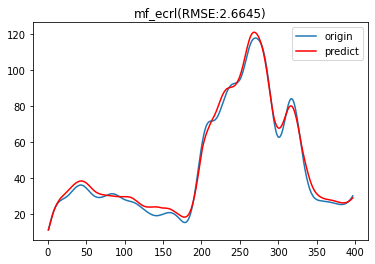

In [61]:
show_x = data_1t6_te
show_y = data_7t12_te
show_l = 397
column = 3
net = net2
net.eval()
net.to('cpu')
criterion = torch.nn.MSELoss()
# predict = net(show_x)
# predict = predict.data.numpy()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1,shuffle=False)
predict_show = []
y_show = []
for batch in test_loader:
    s_x,s_y,_,_,_= batch
    predict = net(s_x) 
    pred2 = predict.detach().numpy()
    predict_show.append(pred2) 
    trainloss = criterion(predict, s_y)
    y_s = s_y.detach().numpy()
    y_show.append(y_s)
predict_show = np.array(predict_show)
y_show = np.array(y_show)
# MSE_show = criterion(predict[:,column], show_y[:,column])
MSE_show =  criterion(torch.Tensor(predict_show[:,:,column]), torch.Tensor(y_show[:,:,column]))
predict = predict.data.numpy()
# 建立等差数列，（起始，终止，个数）
x = np.linspace(1,show_l,show_l)

plt.title('mf_ecrl(RMSE:'+str('%.5g' % torch.sqrt(MSE_show))+')')
# plt.plot(x , show_y[:,column], label='origin')
plt.plot(x , show_y[:,column], label='origin')
# plt.plot(x, predict[:,column], color='red', label='predict')
plt.plot(x, predict_show[:,0,column], color='red', label='predict')
plt.legend()
plt.show()


In [38]:
# checkpointPath_model = model_Dir+'emgsk_fornl_CNN_01'+'_nl_agle_re'+timeForSave+'.pth'
# torch.save(net.state_dict(),checkpointPath_model)
checkpointPath_model = model_Dir+'emgsk_nlv2'+'_onlyMSE_'+timeForSave+'.pth'
torch.save(net.state_dict(),checkpointPath_model)

In [45]:
checkpoint_for_net2 = torch.load(model_Dir+'emgsk_nlv2_onlyMSE_2022_04_10_20_22_21.pth')
net2 = Network()
net2.load_state_dict(checkpoint_for_net2)
# net2.load_state_dict(checkpoint_for_net2['model'])
net2.eval()

Network(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=6, bias=True)
  (dr1): Dropout2d(p=0.2, inplace=False)
)

In [1]:

#对网络进行验证
# column = 0
# show_x = data_123_te
# show_y = data_45_te_y
# show_l = 20
# net.eval()
# net.to('cpu')
# predict = net(show_x)
# # predict = predict.data.numpy()

# # MSE_show = criterion(predict[:,column], show_y[:,column])
# MSE_show = criterion(predict, show_y)
# predict = predict.data.numpy()
# # 建立等差数列，（起始，终止，个数）
# x = np.linspace(1,show_l,show_l)
# # column = 0
# plt.title('MF(RMSE:'+str('%.5g' % torch.sqrt(MSE_show))+')')
# # plt.plot(x , show_y[:,column], label='origin')
# plt.plot(x , show_y, label='origin')
# # plt.plot(x, predict[:,column], color='red', label='predict')
# plt.plot(x, predict, color='red', label='predict')
# plt.legend()
# plt.show()
